In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

plt.rcParams['font.size'] = 15
plt.rc('image', cmap='inferno', interpolation='none', origin='lower')


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

## Load image

In [3]:
sys.setrecursionlimit(10000)

In [50]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [51]:
lsbg_cat = Table.read('./Cutout/Candy/candy_cutout_cat.fits')

In [52]:
lsbg = lsbg_cat[101]

In [53]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['Seq']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [54]:
from kuaizi.utils import set_logger
logger = set_logger('_fitting_wavelet', f'{prefix}-{index}.log')

# Detect sources

In [55]:
pixel_scale = kz.HSC_pixel_scale
tigress = True
show_figure = True
starlet_thresh = 0.5

In [56]:
print('  - Detect sources and make mask')
logger.info('  - Detect sources and make mask')
print('    Query GAIA stars...')
logger.info('    Query GAIA stars...')
gaia_cat, msk_star_ori = kz.utils.gaia_star_mask(  # Generate a mask for GAIA bright stars
    data.images.mean(axis=0),  # averaged image
    data.wcs,
    pixel_scale=pixel_scale,
    gaia_bright=19.5,
    mask_a=694.7,
    mask_b=3.8,
    factor_b=1.0,  # 0.7,
    factor_f=1.4,  # 1.0,
    tigress=tigress,
    logger=logger)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    7 stars from Gaia are masked!


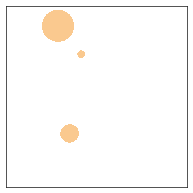

In [57]:
display_single(msk_star_ori.astype(float), cmap=SEG_CMAP, scale='linear', xsize=4, ysize=4);

In [58]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(data.masks)
for i in range(len(data.channels)):
    temp[i][~msk_star_ori.astype(bool)] = 0
    data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 154 objects


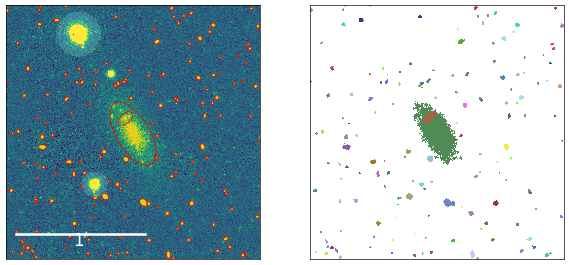

In [59]:
# This vanilla detection with very low sigma finds out where is the central object and its footprint
# if cutout is lareger than 200 arcsec => large galaxy, less aggressive deblend
if max(data.images.shape) * pixel_scale > 200:
    first_dblend_cont = 0.07
else:
    first_dblend_cont = 0.01

    
obj_cat_ori, segmap_ori, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=2, # a.k.a., "sigma"
    mask=msk_star_ori,
    method='vanilla',
    convolve=False,
    match_gaia=False,
    show_fig=show_figure,
    visual_gaia=False,
    b=128,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,
    deblend_nthresh=48,
    deblend_cont=first_dblend_cont,  # 0.01, 0.05, 0.07, I changed it to 0.1
    sky_subtract=True,
    logger=logger)
# segmap_ori[msk_star_ori.astype(bool)] = -1

catalog_c = SkyCoord(obj_cat_ori['ra'], obj_cat_ori['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_ori = obj_cat_ori[np.argsort(dist)[0]]['index'] # ori = original, i.e., first SEP run
cen_obj = obj_cat_ori[cen_indx_ori]

# Better position for cen_obj, THIS IS PROBLEMATIC!!! 
x, y, _ = sep.winpos(data.images.mean(
    axis=0), cen_obj['x'], cen_obj['y'], 6)
ra, dec = data.wcs.wcs_pix2world(x, y, 0)
cen_obj['x'] = x
cen_obj['y'] = y
cen_obj['ra'] = ra
cen_obj['dec'] = dec
cen_obj_coord = SkyCoord(cen_obj['ra'], cen_obj['dec'], unit='deg')

In [60]:
# We roughly guess the box size of the Starlet source
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs,
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

cen_obj = obj_cat_ori[cen_indx_ori]
starlet_source = scarlet.StarletSource(model_frame,
                                       (cen_obj['ra'], cen_obj['dec']),
                                       observation,
                                       thresh=0.01,
                                       min_grad=-0.05,  # the initial guess of box size is as large as possible
                                       starlet_thresh=5e-3)

# If the initial guess of the box is way too large (but not bright galaxy), set min_grad = 0.1.
# The box is way too large
if starlet_source.bbox.shape[1] > 0.9 * data.images[0].shape[0] and (bright):
     # The box is way too large
    min_grad = 0.03
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.9 * data.images[0].shape[0] and (~bright):
    # not bright but large box: something must be wrong! min_grad should be larger
    min_grad = 0.05
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.6 * data.images[0].shape[0] and (bright):
    # If box is large and gal is bright
    min_grad = 0.02
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.6 * data.images[0].shape[0] and (~bright):
    # If box is large and gal is not bright
    min_grad = 0.01
    smaller_box = True
else:
    smaller_box = False
    
if smaller_box:
    starlet_source = scarlet.StarletSource(model_frame,
                                           (cen_obj['ra'], cen_obj['dec']),
                                           observation,
                                           thresh=0.01,
                                           min_grad=min_grad,
                                           starlet_thresh=5e-3)

starlet_extent = kz.display.get_extent(starlet_source.bbox)  # [x1, x2, y1, y2]

# extra padding, to enlarge the box
starlet_extent[0] -= 5
starlet_extent[2] -= 5
starlet_extent[1] += 5
starlet_extent[3] += 5

In [61]:
smaller_box#, min_grad

False

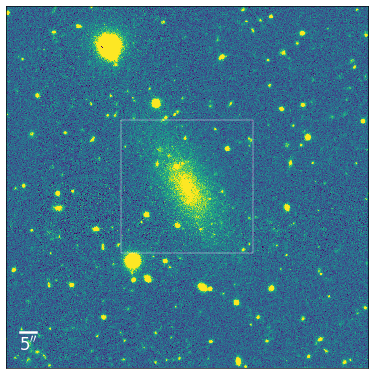

In [62]:
# Show the Starlet initial box
fig = display_single(data.images.mean(axis=0))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "w", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [63]:
if gaia_cat is not None:
    # Find stars within the wavelet box, and mask them.
    star_flag = [(item[0] > starlet_extent[0]) & (item[0] < starlet_extent[1]) &
                 (item[1] > starlet_extent[2]) & (item[1] < starlet_extent[3])
                 for item in np.asarray(gaia_cat['x_pix', 'y_pix'])]
    
    # "star_cat" is a catalog for GAIA stars which fall in the Starlet box
    star_cat = gaia_cat[star_flag]
    
    # Parameters below really matter
    _, msk_star = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
        data.images.mean(axis=0),
        data.wcs,
        gaia_stars=gaia_cat[~np.array(star_flag)],
        pixel_scale=pixel_scale,
        gaia_bright=19.5,
        mask_a=694.7,
        mask_b=3.8,
        factor_b=0.8,
        factor_f=0.6,
        tigress=True,
        logger=None)
else:
    star_cat = []
    msk_star = np.copy(msk_star_ori)

    7 stars from Gaia are masked!


    Detected 188 objects


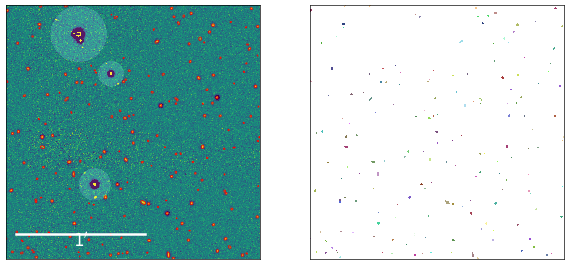

In [64]:
# This step masks out high frequency sources by doing wavelet transformation
obj_cat, segmap_highfreq, bg_rms = kz.detection.makeCatalog([data],
                                                            mask=msk_star,
                                                            lvl=2.,  # 2.5
                                                            method='wavelet',
                                                            high_freq_lvl=2,  # 3
                                                            wavelet_lvl=4,
                                                            match_gaia=False,
                                                            show_fig=show_figure,
                                                            visual_gaia=False,
                                                            b=24,
                                                            f=3,
                                                            pixel_scale=pixel_scale,
                                                            minarea=3,
                                                            deblend_nthresh=30,
                                                            deblend_cont=0.03,
                                                            sky_subtract=True,
                                                            logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_highfreq = obj_cat[np.argsort(dist)[0]]['index']

### Don't mask out objects that fall in the segmap of the central object and the Starlet box
segmap = segmap_highfreq.copy()
# overlap_flag is for objects which fall in the footprint 
# of central galaxy in the fist SEP detection
overlap_flag = [(segmap_ori == (cen_indx_ori + 1))[item]
                for item in list(zip(obj_cat['y'].astype(int), obj_cat['x'].astype(int)))]
overlap_flag = np.array(overlap_flag)

# `box_flag` is for objects which fall in the initial Starlet box
box_flag = np.unique(
    segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    overlap_flag[box_flag] = True
if len(overlap_flag) > 0:
    obj_cat_cpct = obj_cat[overlap_flag] # obj_cat_cpct is the catalog for compact sources

# Remove the source from `obj_cat_cpct` if it is the central galaxy
if dist[cen_indx_highfreq] < 1 * u.arcsec:
    obj_cat_cpct.remove_rows(
        np.where(obj_cat_cpct['index'] == cen_indx_highfreq)[0])

for ind in np.where(overlap_flag)[0]:
    segmap[segmap == ind + 1] = 0

smooth_radius = 2
gaussian_threshold = 0.03
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
# This `seg_mask` only masks compact sources
seg_mask = (mask_conv >= gaussian_threshold)

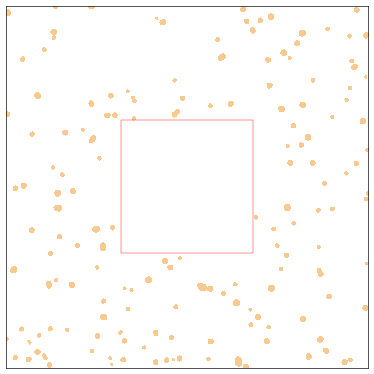

In [65]:
fig = display_single(seg_mask.astype(float), cmap=SEG_CMAP, scale='linear')
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
#print(rect)
ax = plt.gca()
ax.add_patch(rect)

    Detected 75 objects


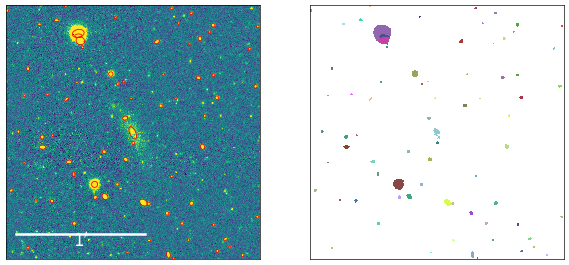

In [66]:
# This step masks out bright and large contamination, which is not well-masked in previous step
obj_cat, segmap_big, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=4.5,  # relative agressive threshold
    method='vanilla',
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,   # only want large things
    deblend_nthresh=36,
    deblend_cont=0.01,
    sky_subtract=True,
    logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_big = obj_cat_ori[np.argsort(dist)[0]]['index']

# mask out big objects that are NOT identified in the high_freq step
segmap = segmap_big.copy()
segbox = segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]
box_flag = np.unique(segbox) - 1
if len(box_flag) > 0:
    box_flag = np.delete(np.sort(box_flag), 0)
    for ind in box_flag:
        if np.sum(segbox == ind + 1) / np.sum(segmap == ind + 1) > 0.5: segmap[segmap == ind + 1] = 0
    box_flag = np.delete(box_flag, np.where(box_flag == cen_indx_big)[
        0])  # dont include the central galaxy
    obj_cat_big = obj_cat[box_flag]
else:
    obj_cat_big = obj_cat

# `obj_cat_big` is catalog of the big/high SNR objects in the image
    
smooth_radius = 5
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
# This `seg_mask_large` masks large bright sources
seg_mask_large = (mask_conv >= gaussian_threshold)

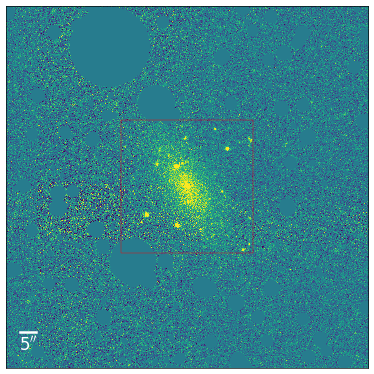

In [67]:
# Combine all masks (stars, compact sources, large sources) and display
fig = display_single(data.images[2] * (~(seg_mask_large + seg_mask + msk_star.astype(bool))))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [68]:
# Set weights of masked pixels to zero
for layer in data.weights:
    layer[msk_star.astype(bool)] = 0
    layer[seg_mask.astype(bool)] = 0
    layer[seg_mask_large.astype(bool)] = 0

In [69]:
# Remove compact objects that are too close to the central
# We don't want to shred the central galaxy
catalog_c = SkyCoord(obj_cat_cpct['ra'], obj_cat_cpct['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
obj_cat_cpct.remove_rows(np.where(dist < 3 * u.arcsec)[0])

# Remove objects in `obj_cat_cpct` that are already masked! 
# (since our final mask is combined from three masks)
inside_flag = [
    seg_mask_large[item] for item in list(
        zip(obj_cat_cpct['y'].astype(int), obj_cat_cpct['x'].astype(int)))
]
obj_cat_cpct.remove_rows(np.where(inside_flag)[0])

# Remove big objects that are toooo near to the target
catalog_c = SkyCoord(obj_cat_big['ra'], obj_cat_big['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
#obj_cat_big.remove_rows(np.where(dist < 3 * u.arcsec)[0])
obj_cat_big.remove_rows(np.where(
    dist < 2 * np.sqrt(
        cen_obj['a'] * cen_obj['b']) * pixel_scale * u.arcsec)[0]) # 2 times effective radius

# Remove objects in `obj_cat_big` that are already masked!
inside_flag = [
    (data.weights[0] == 0)[item] for item in list(
        zip(obj_cat_big['y'].astype(int), obj_cat_big['x'].astype(int)))
]
obj_cat_big.remove_rows(np.where(inside_flag)[0])

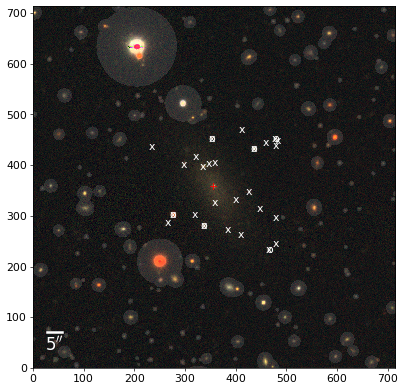

In [70]:
# Visualize our data

weights = copy.copy(data.weights)
mask = (np.sum(data.weights == 0, axis=0) != 0)

ax = display_rgb(data.images, mask=mask, stretch=2, Q=1)

# Mark all of the sources from the detection cataog
plt.text(cen_obj["x"], cen_obj["y"], '+', color="red", 
         horizontalalignment='center', verticalalignment='center')
for k, src in enumerate(obj_cat_cpct):
    plt.text(src["x"], src["y"], 'x', color="w", 
             horizontalalignment='center', verticalalignment='center') # src['index']
    
for k, src in enumerate(obj_cat_big):
    plt.text(src["x"], src["y"], 'o', color="w", 
             horizontalalignment='center', verticalalignment='center') # src['index']

# Model selection

In [71]:
# Construct `scarlet` frames and observation
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs,
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

In [72]:
starlet_mask = (
    (np.sum(observation.weights == 0, axis=0) != 0) + msk_star_ori + (~((segmap_ori == 0) | (segmap_ori == cen_indx_ori + 1)))
               ).astype(bool)
# When estimating the starlet box and SED, we need to mask out saturated pixels and nearby bright stars. 

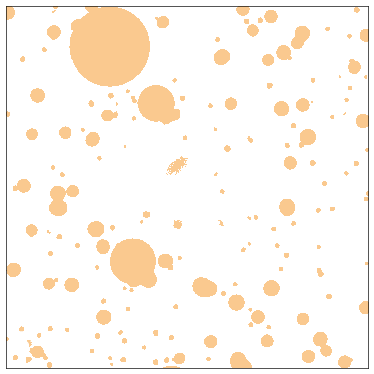

In [73]:
display_single(starlet_mask.astype(float), cmap=SEG_CMAP, scale='linear');

In [79]:
sources = []

# Add central Starlet source
src = obj_cat_ori[cen_indx_ori]
# Find a better box, not too large, not too small. 
if smaller_box:
    min_grad_range = np.arange(min_grad, 0.3, 0.05)
else:
    min_grad_range = np.arange(-0.2, 0.3, 0.05)  # I changed -0.3 to -0.2

# We calculate the ratio of contaminants' area over the box area
# Then the box size is decided based on this ratio.
contam_ratio_list = []
for k, min_grad in enumerate(min_grad_range):
    if k == len(min_grad_range) - 1:
        # if min_grad reaches its maximum, and `contam_ratio` is still very large, 
        # we choose the min_grad with the minimum `contam_ratio`
        min_grad = min_grad_range[np.argmin(contam_ratio_list)]
    
    starlet_source = StarletSource(
        model_frame,
        (src['ra'], src['dec']),
        observation,
        star_mask=starlet_mask,  # bright stars are masked when estimating morphology
        satu_mask=data.masks,  # saturated pixels are masked when estimating SED
        thresh=0.01, # 1
        min_grad=min_grad,
        starlet_thresh=starlet_thresh)
    starlet_extent = kz.display.get_extent(starlet_source.bbox)
    segbox = segmap_ori[starlet_extent[2]:starlet_extent[3],
                        starlet_extent[0]:starlet_extent[1]]
    contam_ratio = 1 - \
        np.sum((segbox == 0) | (segbox == cen_indx_ori + 1)) / \
        np.sum(np.ones_like(segbox))
    print(contam_ratio)
    
    if (contam_ratio <= 0.08 and (~smaller_box)) or (contam_ratio <= 0.10 and (smaller_box or bright)):
        break
    else:
        contam_ratio_list.append(contam_ratio)


logger.info('  - Wavelet modeling with the following hyperparameters:')
print(f'  - Wavelet modeling with the following hyperparameters:')
logger.info(
    f'    min_grad = {min_grad:.2f}, starlet_thresh = {starlet_thresh:.2f} (contam_ratio = {contam_ratio:.2f}).')
print(
    f'    min_grad = {min_grad:.2f}, starlet_thresh = {starlet_thresh:.2f} (contam_ratio = {contam_ratio:.2f}).'
)

starlet_source.center = (
    np.array(starlet_source.bbox.shape) // 2 + starlet_source.bbox.origin)[1:]
sources.append(starlet_source)

0.027612630466375965
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.50 (contam_ratio = 0.03).


In [80]:
## Add a compact source to model NSC
NSC = scarlet.source.CompactExtendedSource(
                    model_frame, (src['ra'], src['dec']),
                    observation, shifting=True)
sources.append(NSC)

In [81]:
# Only model "real compact" sources
if len(obj_cat_big) > 0:
    # remove intersection between cpct and big objects
    # if an object is both cpct and big, we think it is big
    cpct_coor = SkyCoord(
        ra=np.array(obj_cat_cpct['ra']) * u.degree,
        dec=np.array(obj_cat_cpct['dec']) * u.degree)
    big = SkyCoord(ra=obj_cat_big['ra'] * u.degree,
                   dec=obj_cat_big['dec'] * u.degree)
    tempid, sep2d, _ = match_coordinates_sky(big, cpct_coor)
    cpct = obj_cat_cpct[np.setdiff1d(
        np.arange(len(obj_cat_cpct)), tempid[np.where(sep2d < 1 * u.arcsec)])]
else:
    cpct = obj_cat_cpct

if len(star_cat) > 0 and len(cpct) > 0:
    # remove intersection between cpct and stars
    # if an object is both cpct and star, we think it is star
    star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
    cpct_coor = SkyCoord(
        ra=np.array(cpct['ra']) * u.degree,
        dec=np.array(cpct['dec']) * u.degree)
    tempid, sep2d, _ = match_coordinates_sky(star, cpct_coor)
    cpct = cpct[np.setdiff1d(np.arange(len(cpct)),
                             tempid[np.where(sep2d < 1 * u.arcsec)])]

if not bright:
    # for bright galaxy, we don't include these compact sources into modeling,
    # due to the limited computation resources
    for k, src in enumerate(cpct):
        if src['fwhm_custom'] < 3:
            new_source = scarlet.source.PointSource(
                model_frame, (src['ra'], src['dec']), observation)
        elif src['fwhm_custom'] >= 3 and src['fwhm_custom'] < 5:
            new_source = scarlet.source.CompactExtendedSource(
                model_frame, (src['ra'], src['dec']), observation)
        else:
            new_source = scarlet.source.SingleExtendedSource(
                model_frame, (src['ra'], src['dec']), observation, thresh=2, min_grad=0.2)
        sources.append(new_source)

# IF GAIA stars are within the box: exclude it from the big_cat
if len(obj_cat_big) > 0:
    if len(star_cat) > 0:
        star = SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg')
        tempid, sep2d, _ = match_coordinates_sky(big, star)
        big_cat = obj_cat_big[np.setdiff1d(
            np.arange(len(obj_cat_big)), np.where(sep2d < 1.5 * u.arcsec)[0])]
        # big_cat = obj_cat_big[np.setdiff1d(
        #     np.arange(len(obj_cat_big)), tempid[np.where(sep2d < 1 * u.arcsec)])]
    else:
        big_cat = obj_cat_big

    for k, src in enumerate(big_cat):
        if src['fwhm_custom'] > 22: # different params for very bright big objects
            new_source = scarlet.source.ExtendedSource(
                model_frame, (src['ra'], src['dec']),
                observation,
                K=2, thresh=2, shifting=True, min_grad=0.2)
        else:
            try:
                new_source = scarlet.source.SingleExtendedSource(
                    model_frame, (src['ra'], src['dec']),
                    observation, satu_mask=data.masks,  # helps to get SED correct
                    thresh=2, shifting=False, min_grad=0.2)
            except Exception as e:
                print(e)
        sources.append(new_source)

if len(star_cat) > 0:
    for k, src in enumerate(star_cat):
        try:
            if src['phot_g_mean_mag'] < 18:
                new_source = scarlet.source.ExtendedSource(
                    model_frame, (src['ra'], src['dec']),
                    observation,
                    K=2, thresh=5, shifting=True, min_grad=0.4)
            else:
                new_source = scarlet.source.SingleExtendedSource(
                    model_frame, (src['ra'], src['dec']),
                    observation, satu_mask=data.masks,
                    thresh=2, shifting=False, min_grad=0.)
        except Exception as e:
            print(e)
        
        sources.append(new_source)

print(f'    Total number of sources: {len(sources)}')
logger.info(f'    Total number of sources: {len(sources)}')

    Total number of sources: 28


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

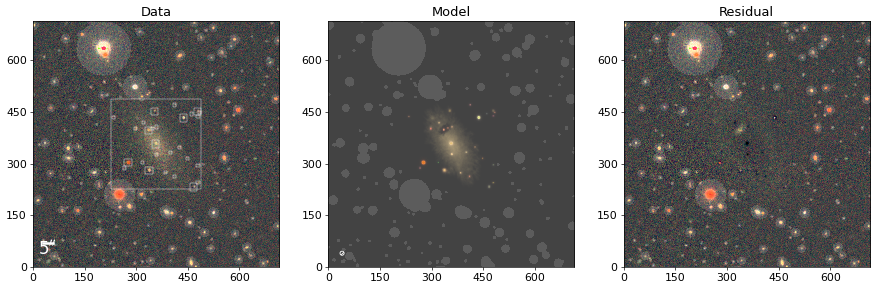

In [82]:
blend = scarlet.Blend(sources, observation)
kz.display.display_scarlet_model(
    blend,
    #show_ind=[0],
    #zoomin_size=80,
    minimum=-0.3,
    stretch=1,
    add_boxes=True,
    channels=channels,
    show_mask=False,
    show_mark=False)

In [83]:
model_dir='./Model/'

In [84]:
if bright:
    e_rel_list = [5e-4, 1e-5]  # otherwise it will take forever....
    n_iter = 100
else:
    e_rel_list = [5e-4, 1e-5, 5e-5, 1e-6]
    n_iter = 150

blend.fit(n_iter, 1e-4)

with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
    dill.dump([blend, {'starlet_thresh': starlet_thresh,
                       'e_rel': 1e-4, 'loss': blend.loss[-1]}, None], fp)
    fp.close()
last_loss = blend.loss[-1]
logger.info(
    f'    Optimizaiton: Succeed for e_rel = 1e-04 with {len(blend.loss)} iterations! Try higher accuracy!')
print(
    f'    Optimizaiton: Succeed for e_rel = 1e-04 with {len(blend.loss)} iterations! Try higher accuracy!')

for i, e_rel in enumerate(e_rel_list):
    blend.fit(150, e_rel)
    if len(blend.loss) > 50:  # must have more than 50 iterations
        recent_loss = np.mean(blend.loss[-10:])
        min_loss = np.min(blend.loss[:-10])
        if recent_loss < min_loss:
            logger.info(
                f'    Optimizaiton: Succeed for e_rel = {e_rel} with {len(blend.loss)} iterations! Try higher accuracy!')
            print(
                f'    Optimizaiton: Succeed for e_rel = {e_rel} with {len(blend.loss)} iterations! Try higher accuracy!')
            with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
                dill.dump(
                    [blend, {'starlet_thresh': starlet_thresh, 'e_rel': e_rel, 'loss': blend.loss[-1]}, None], fp)
                fp.close()
        elif abs((recent_loss - min_loss) / min_loss) < 0.02:
            if recent_loss < last_loss:  # better than the saved model
                logger.info(
                    f'    Optimizaiton: I am okay with relative loss difference = {abs((recent_loss - min_loss) / min_loss)}. Fitting stopped.')
                print(
                    f'    Optimizaiton: I am okay with relative loss difference = {abs((recent_loss - min_loss) / min_loss)}. Fitting stopped.')
                with open(os.path.join(model_dir, f'{prefix}-{index}-trained-model-wavelet.df'), 'wb') as fp:
                    dill.dump(
                        [blend, {'starlet_thresh': starlet_thresh, 'e_rel': e_rel, 'loss': blend.loss[-1]}, None], fp)
                    fp.close()
                break
        else:
            logger.info(
                f'  ! Optimizaiton: Cannot achieve a global optimization with e_rel = {e_rel}.')
            print(
                f'  ! Optimizaiton: Cannot achieve a global optimization with e_rel = {e_rel}.')
    else:
        continue
        
        
if len(blend.loss) < 50:
    logger.warning(
        '  ! Might be poor fitting! Iterations less than 50.')
    print('  ! Might be poor fitting! Iterations less than 50.')
logger.info("  - After {1} iterations, logL = {2:.2f}".format(
    e_rel, len(blend.loss), -blend.loss[-1]))
print("  - After {1} iterations, logL = {2:.2f}".format(
    e_rel, len(blend.loss), -blend.loss[-1]))


    Optimizaiton: Succeed for e_rel = 1e-04 with 8 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-06 with 70 iterations! Try higher accuracy!
  - After 70 iterations, logL = 2264398.02


### Inspect the model

In [85]:
# In principle, Now we don't need to find which components compose a galaxy. The central Starlet is enough!
if len(blend.sources) > 1:
    mag_mat = np.array(
        [-2.5 * np.log10(kz.measure.flux(src, observation)) + 27 for src in sources])
    # g - r, g - i, g - z
    color_mat = (- mag_mat + mag_mat[:, 0][:, np.newaxis])[:, 1:]
    color_dist = np.linalg.norm(
        color_mat - color_mat[0], axis=1) / np.linalg.norm(color_mat[0])
    sed_ind = np.where(color_dist < 0.1)[0]
    dist = np.array([
        np.linalg.norm(
            src.center - blend.sources[0].center) * pixel_scale
        for src in np.array(blend.sources)[sed_ind]
    ])
    dist_flag = (
        dist < 3 * np.sqrt(cen_obj['a'] * cen_obj['b']) * pixel_scale)

    # maybe use segmap flag? i.e., include objects that are overlaped
    # with the target galaxy in the inital detection.

    point_flag = np.array([
        isinstance(src, scarlet.source.PointSource)
        for src in np.array(blend.sources)[sed_ind]
    ])  # we don't want point source

    near_cen_flag = [
        (segmap_ori == cen_indx_ori +
         1)[int(src.center[0]), int(src.center[1])]  # src.center: [y, x]
        for src in np.array(blend.sources)[sed_ind]
    ]

    sed_ind = sed_ind[(~point_flag) & near_cen_flag & dist_flag]

    if not 0 in sed_ind:
        # the central source must be included.
        sed_ind = np.array(list(set(sed_ind).union({0})))
else:
    sed_ind = np.array([0])

print(
    f'  - Components {sed_ind} are considered as the target galaxy.')

  - Components [0 1] are considered as the target galaxy.


In [96]:
src = blend.sources[1]

In [100]:
src.center.astype(int)

Parameter([357, 355])

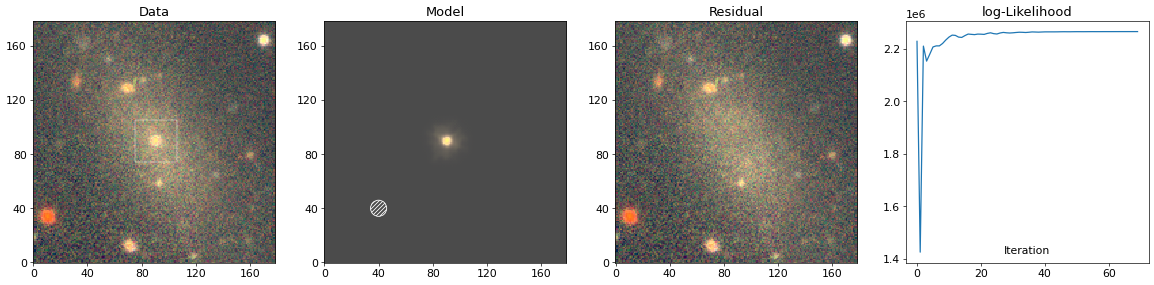

In [104]:
fig = kz.display.display_scarlet_model(
        blend,
        show_ind=[1], #range(1, len(sources)),#[1, 2, 3, 4, 5,],
        zoomin_size=30,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels=data.channels,
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

In [36]:
# Only mask bright stars!!!

# Generate a VERY AGGRESSIVE mask, named "footprint"
footprint = np.zeros_like(segmap_highfreq, dtype=bool)
# for ind in cpct['index']:  # mask ExtendedSources which are modeled
#     footprint[segmap_highfreq == ind + 1] = 1

# footprint[segmap_highfreq == cen_indx_highfreq + 1] = 0
sed_ind_pix = np.array([item.center for item in np.array(
    sources)[sed_ind]]).astype(int)  # the y and x of sed_ind objects
# if any objects in `sed_ind` is in `segmap_highfreq`
# sed_corr_indx = segmap_highfreq[(sed_ind_pix[:, 0], sed_ind_pix[:, 1])]
# for ind in sed_corr_indx:
#     footprint[segmap_highfreq == ind] = 0

# smooth_radius = 1.5
# gaussian_threshold = 0.03
# mask_conv = np.copy(footprint)
# mask_conv[mask_conv > 0] = 1
# mask_conv = convolve(mask_conv.astype(
#     float), Gaussian2DKernel(smooth_radius))
# footprint = (mask_conv >= gaussian_threshold)

### Mask star within the box
if len(star_cat) > 0:
    _, star_mask = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
            data.images.mean(axis=0),
            data.wcs,
            gaia_stars=star_cat,
            pixel_scale=pixel_scale,
            gaia_bright=19.0,
            mask_a=694.7, 
            mask_b=3.8,
            factor_b=0.9,
            factor_f=1.0, 
            tigress=True)
    footprint = footprint | star_mask
    
### Mask big objects from `big_cat`
if len(obj_cat_big) > 0:
    # Blow-up radius depends on the distance to target galaxy
    catalog_c = SkyCoord(big_cat['ra'], big_cat['dec'], unit='deg')
    dist = lsbg_coord.separation(catalog_c)
    near_flag = (dist < 4 * cen_obj['a'] * pixel_scale * u.arcsec)
    
    mask_big_near = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[near_flag]['index']:  # mask ExtendedSources which are modeled
        mask_big_near[segmap_big == ind + 1] = 1
    smooth_radius = 1.5
    gaussian_threshold = 0.1
    mask_conv = np.copy(mask_big_near)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    mask_big_near = (mask_conv >= gaussian_threshold)
    
    mask_big_far = np.zeros_like(segmap_big, dtype=bool)
    for ind in big_cat[~near_flag]['index']:  # mask ExtendedSources which are modeled
        mask_big_far[segmap_big == ind + 1] = 1
    smooth_radius = 5
    gaussian_threshold = 0.01
    mask_conv = np.copy(mask_big_far)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(
        float), Gaussian2DKernel(smooth_radius))
    mask_big_far = (mask_conv >= gaussian_threshold)
    
        # if any objects in `sed_ind` is in `segmap_big`
#     sed_corr_indx = segmap_big[sed_ind_pix[:, 0], sed_ind_pix[:, 1]]
#     for ind in sed_corr_indx:
#         footprint2[segmap_big == ind + 1] = 0
#     footprint2[segmap_big == cen_indx_big + 1] = 0

    footprint = footprint + mask_big_near + mask_big_far # This is the mask for everything except target galaxy

In [37]:
# zoomin_size: in arcsec, rounded to integer multiple of 30 arcsec
zoomin_size = np.ceil(
    (sources[0].bbox.shape[1] * pixel_scale * 3) / 30) * 30
# cannot exceed the image size
zoomin_size = min(zoomin_size, data.images.shape[1] * pixel_scale)

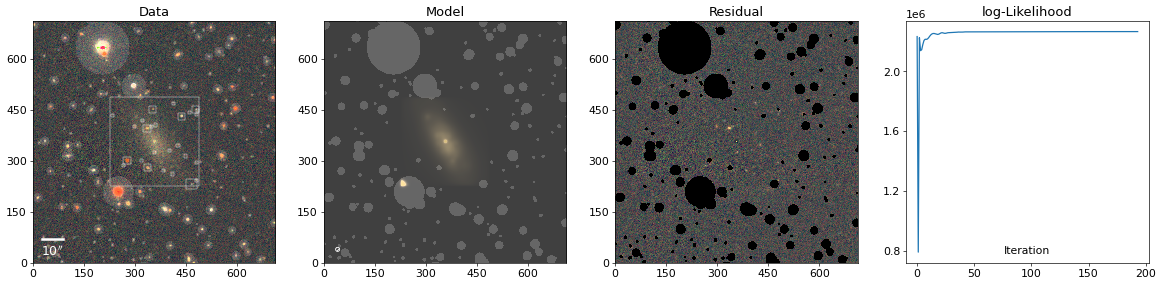

In [38]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            footprint,
            show_ind=sed_ind,
            zoomin_size=zoomin_size,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=data.channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

In [ ]:
# stlt_src_center = scarlet.StarletSource(
#     model_frame,
#     (src['ra'], src['dec']),
#     observation,
#     sat_mask=sat_mask,
#     thresh=0.01,
#     min_grad=0.05,
#     starlet_thresh=starlet_thresh)

# ref_sed = 27.0 - 2.5 * np.log10(kz.measure.flux(stlt_src_center, observation))
#sed = 27.0 - 2.5 * np.log10(kz.measure.flux(starlet_source, observation))
    #color_dist = np.linalg.norm(sed - ref_sed)
    # and color_dist < 0.5:
   # print(
#     f'    sed diff = {(sed - ref_sed)}, sed diff fraction = {color_dist:.2f}.'
# )

# for min_grad in np.arange(0., 0.4, 0.05):
#     starlet_source = scarlet.StarletSource(
#         model_frame,
#         (src['ra'], src['dec']),
#         observation,
#         thresh=0.01,
#         min_grad=min_grad,
#         starlet_thresh=1)
#     starlet_extent = kz.display.get_extent(starlet_source.bbox)
#     segbox = segmap_ori[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]
#     contam_ratio = 1 - np.sum((segbox == 0) | (segbox == cen_indx_ori + 1)) / np.sum(np.ones_like(segbox))
#     if contam_ratio < 0.1:
#         break
# print(f'min_grad = {min_grad:.2f}, contam_ratio = {contam_ratio:.2f}')
# starlet_source.center = (np.array(starlet_source.bbox.shape) // 2 + starlet_source.bbox.origin)[1:]
# sources.append(starlet_source)
